In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'wind-solar-electricity-production:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3570391%2F6217083%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240426%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240426T075240Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D46b03c4683cc187c8024dd8d7672333a97473f190bbb6c8f4f59d233055ef9080e2e0d92ca3dcbf85c90357e1ab30f49c5a956e36c7e6ee5b416dacd4c3692790aa0a790d0db56dff7eac5cfe756fc52760d92acd76ee9d24bf5383027e125e1a1b14e5d69c938d0011c3e1c1e25a1e9662d9b1f5d6efaddb78556977f41cf5b23830dec9a6e994eb7eee746d95b68438ffde93b2888e2021d10d05505d2e7db47940e91099bbf5179ce858e8f1a76912f5bc78f76454efed44da10bd7af4fd46f94494f0ec8d62a8b68378af0e5dcb03a8825aa60077becea285c25303cd5b77fbfe363fa58d6342d89536a98e737d0dca26c4ddb1678596cb62b2f53c5ce1b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 587420 bytes downloaded
Downloaded and uncompressed: wind-solar-electricity-production
Data source import complete.


# Loading Necessary libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Loading Data

This dataset consists of monthly wind and solar energy production records on an hourly basis for the French grid since 2020.

In [ ]:
data_path = "/kaggle/input/wind-solar-electricity-production/intermittent-renewables-production-france.csv"
# Droping 'Date and Hour' column
df = pd.read_csv(data_path).drop(columns=["Date and Hour"])
df.head()

,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
0,2020-07-22,20:00:00,21:00:00,Solar,244.0,204,Wednesday,July
1,2020-07-23,07:00:00,08:00:00,Solar,223.0,205,Thursday,July
2,2020-07-23,16:00:00,17:00:00,Solar,2517.0,205,Thursday,July
3,2020-07-23,19:00:00,20:00:00,Solar,658.0,205,Thursday,July
4,2020-07-23,23:00:00,24:00:00,Solar,0.0,205,Thursday,July


# Data Preprocessing


In [ ]:
# checking data types
df.dtypes

Date           object
StartHour      object
EndHour        object
Source         object
Production    float64
dayOfYear       int64
dayName        object
monthName      object
dtype: object

The dataset may contain null values. Thus, we take the approach of:

1. Droping null Categorical values if there are any.
2. Replacing null Numerical values if any, either with the prevoiusly (hourly) recorded value or the average of the previous and next recorded values.

First, we need to sort the dataset based on dates and work starting hours, since some entries might have had delayed recording or might have just been misplaced.

In [ ]:
# Checking for null values
# approach:
#    1. deleting null Categorical values if any
#    2. filling null Numerical vlaues if any

# sorting the data based on the date and working hour
df = df.sort_values(by=["Date","StartHour"])
df = df.reindex(list(range(len(df))))
df.isnull().sum()

Date          0
StartHour     0
EndHour       0
Source        0
Production    2
dayOfYear     0
dayName       0
monthName     0
dtype: int64

In [ ]:
null_rows = df[df.isnull().any(axis=1)]
null_rows
# The sources are different.

,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
36164,2022-03-27,02:00:00,03:00:00,Solar,NaN,86,Sunday,March
39321,2022-03-27,02:00:00,03:00:00,Wind,NaN,86,Sunday,March


In [ ]:
# first approach: filling the null values with the mean value of the respective day
#------------------------------------------------------------------1
# # calculating the mean production for every day based on the source
# solar_wind_mean = np.round(df.groupby(by=["Source", "Date"])["Production"].mean())

# for idx in null_rows.index:
#     df.at[idx, "Production"] = solar_wind_mean[df.iloc[idx].Source, df.iloc[idx].Date]
#------------------------------------------------------------------1


# filling the null values with the vlaues of their previous rows (previous hour)
df = df.fillna(method="ffill")
df.iloc[null_rows.index]

# another approach: filling the null values with
# the average of thier next and previous vlaues (next and previous hour)

,Date,StartHour,EndHour,Source,Production,dayOfYear,dayName,monthName
36164,2022-03-27,02:00:00,03:00:00,Solar,4.0,86,Sunday,March
39321,2022-03-27,02:00:00,03:00:00,Wind,7675.0,86,Sunday,March


In [ ]:
df["year"] = df.Date.str.split("-", expand=True)[0]

# Data Visualization

### 1. Yearly Energy Production

In [ ]:
yearly_production = df.groupby(by=["Source", "year"]).Production.sum().reset_index()
yearly_production

,Source,year,Production
0,Solar,2020,6389965.0
1,Solar,2021,8323800.0
2,Solar,2022,10939292.0
3,Solar,2023,6307001.0
4,Wind,2020,35372922.0
5,Wind,2021,36423417.0
6,Wind,2022,38569740.0
7,Wind,2023,24705728.0


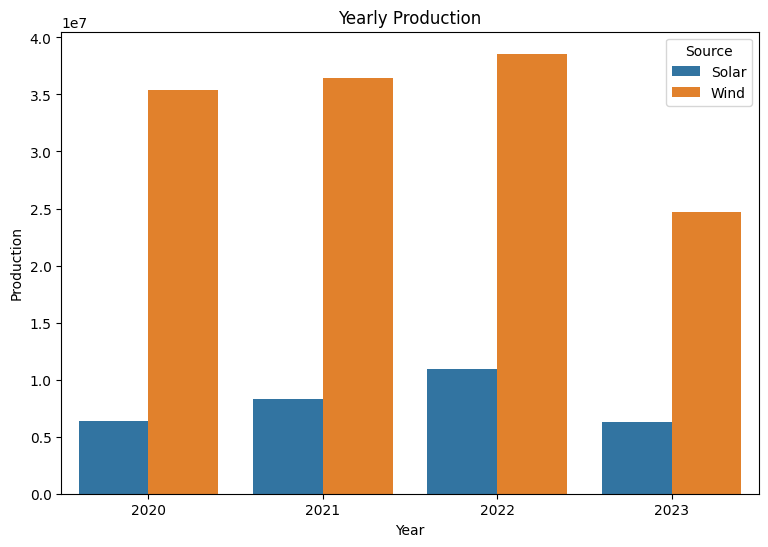

In [ ]:
plt.figure(figsize=(9, 6))
sns.barplot(data=yearly_production, x="year", y="Production", hue="Source")
plt.title("Yearly Production")
plt.xlabel("Year")
plt.ylabel("Production")
plt.show()

Based on the plot above, we conclude that the source of a large proportion of renewable energy produced yearly is mainly wind. Also, we can observe a positive energy production rate in both sources as years pass.

__Note__: the second half of the year 2023 hasn't arrived yet, therefor it hasn't been recorded yet.

### 2. Monthly Energy Production in Every Year

In [ ]:
month_order = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6, "July": 7,
               "August": 8, "September": 9, "October": 10, "November": 11, "December": 12}

In [ ]:
year_month_production = df.groupby(by=["Source", "year", "monthName"]).Production.sum().reset_index()
# sorting values based on the months
year_month_production = year_month_production.sort_values(by="monthName", key=lambda x: x.map({m: i for i, m in enumerate(month_order)}))

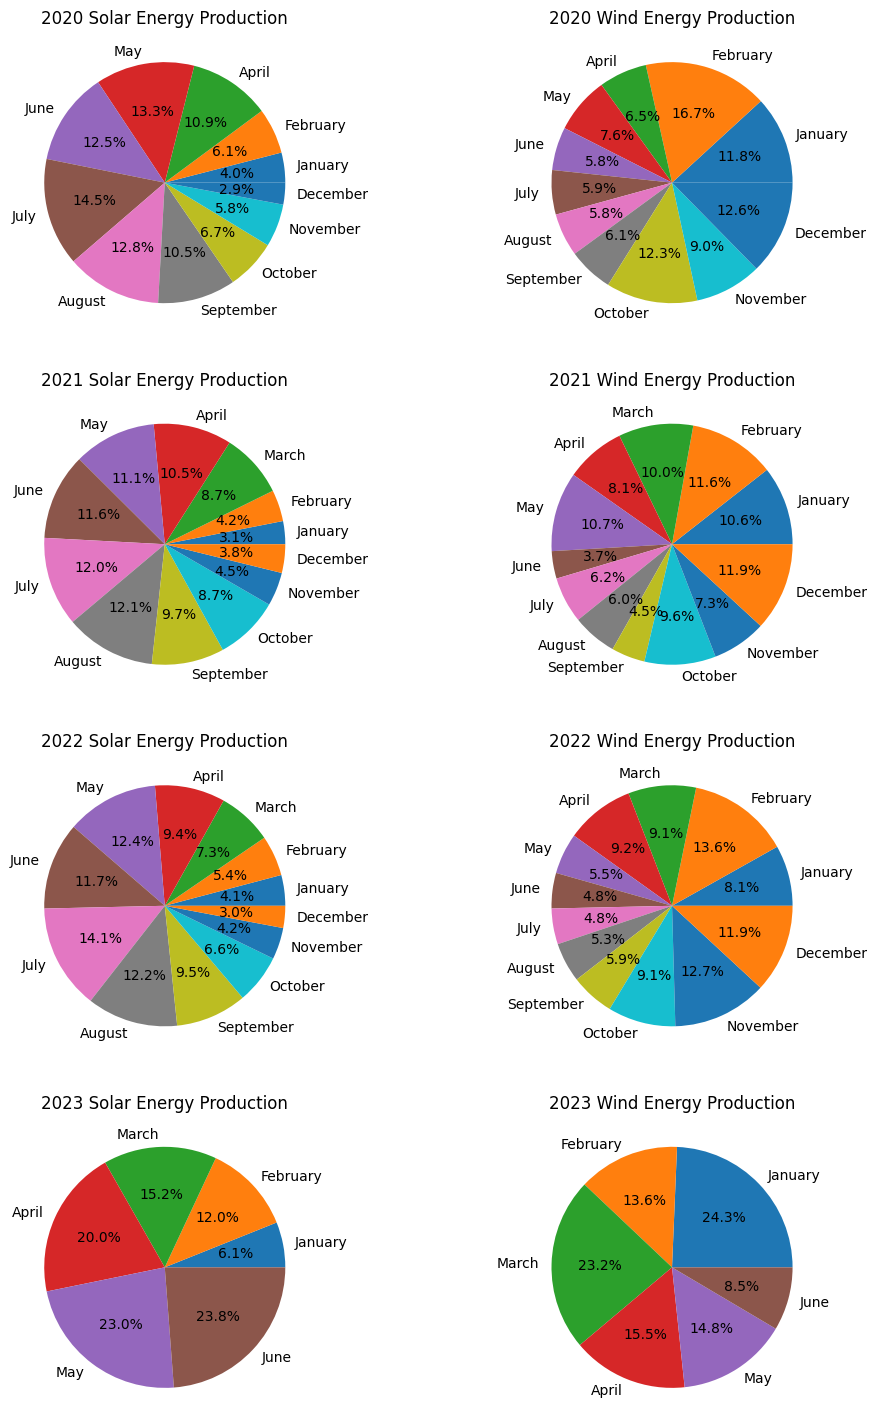

In [ ]:
years = sorted(year_month_production.year.unique())

plt.figure(figsize=(12, 18))
plt.subplot(4, 2, 8)

for i, year in enumerate(years):

    months = year_month_production[year_month_production.year == year].monthName.unique()
    plt.subplot(4, 2, i*2 + 1)

    rule = lambda x: x[x.year == year][x.Source == "Solar"]
    X_solar = rule(year_month_production).Production
    plt.pie(X_solar, labels=months, autopct='%1.1f%%')
    plt.title(f"{year} Solar Energy Production")

    plt.subplot(4, 2, i*2 + 2)

    rule = lambda x: x[x.year == year][x.Source == "Wind"]
    X_wind = rule(year_month_production).Production
    plt.pie(X_wind, labels=months, autopct='%1.1f%%')
    plt.title(f"{year} Wind Energy Production")

plt.show()

It's visible from the pie charts above that each year, more than $\frac23$ of solar production is in the hot half of the year, where there is a longer daytime (Spring and Summer). On the other hand, wind energy production in the cold half of the year (Fall and Winter) makes up more than 60% of the whole wind production. These observations are logical since France lies in the northern hemisphere, and daytime is longer during the hot half of the year, and the wind blows faster during the cold half in the northern hemisphere.

Also, from the charts above and the following charts below, it's visible that the values for March 2020 are missing. Let's make predicting those values a task to do.

### 3. Daily Energy Production

In [ ]:
daily_production = df.groupby(by=["Source","Date"]).Production.sum().reset_index()
daily_production["Date"] = pd.to_datetime(daily_production["Date"])

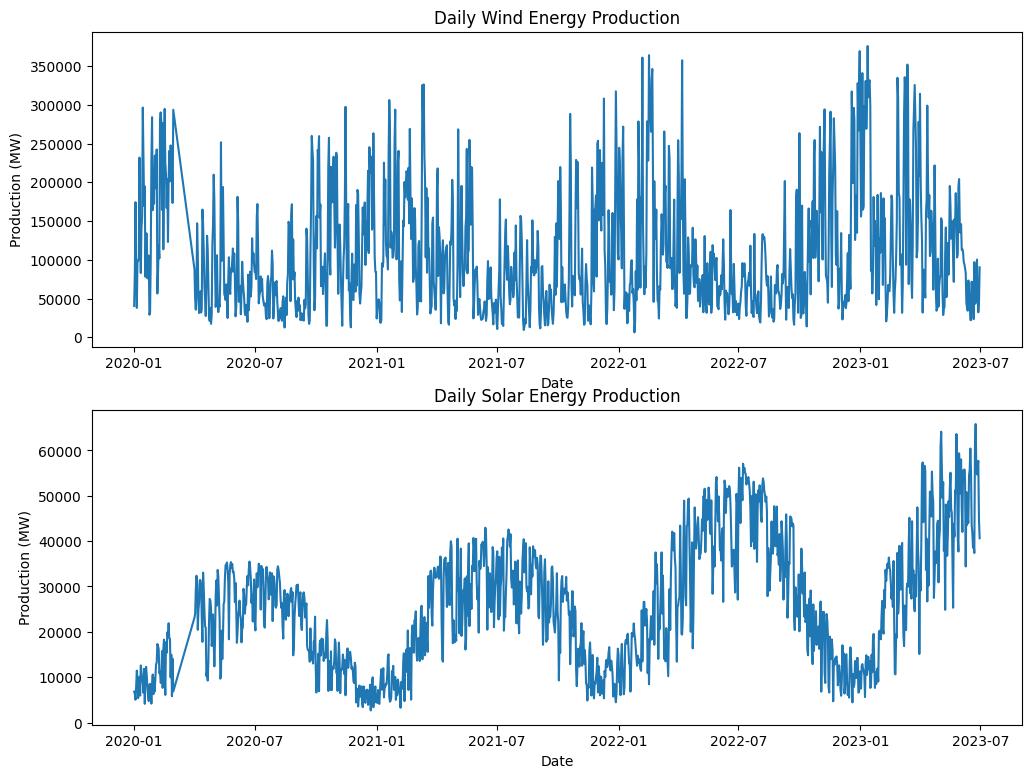

In [ ]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 1, 2)

plt.subplot(2, 1, 1)
plt.title("Daily Wind Energy Production")
sns.lineplot(data=daily_production[daily_production.Source=="Wind"], x="Date", y="Production",)
plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.subplot(2, 1, 2)
plt.title("Daily Solar Energy Production")
sns.lineplot(data=daily_production[daily_production.Source=="Solar"], x="Date", y="Production")
plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.show()

# Training LSTM Model for Predicting Missing March Values


### Data Preparation

In [ ]:
# cutting January and February 2020 values from the whole data
cuted_daily_production = daily_production[daily_production.Date >= "2020-04-01"]
cuted_daily_production.set_index("Date", inplace=True, drop=True)

In [ ]:
test_size = 150 # Predicting the last "test_size" values

# MinMaxScalers for scaling the production values into the [0, 1] range
Solar_scaler = MinMaxScaler(feature_range=(0, 1))
Wind_scaler = MinMaxScaler(feature_range=(0, 1))

# fitting the Scalers to the WHOLE data (including January and February 2020)
Solar_scaler.fit(daily_production[daily_production.Source == "Solar"][-test_size::-1].Production.values.reshape(-1, 1))
Wind_scaler.fit(daily_production[daily_production.Source == "Wind"][-test_size::-1].Production.values.reshape(-1, 1))

# Transforming the cuted data
Solar_data = Solar_scaler.transform(cuted_daily_production[cuted_daily_production.Source == "Solar"][-test_size::-1].Production.values.reshape(-1, 1))
Wind_data = Wind_scaler.transform(cuted_daily_production[cuted_daily_production.Source == "Wind"][-test_size::-1].Production.values.reshape(-1, 1))

In [ ]:
# A function for creating dataset for the model to work with
# returns "X" of shape (num_batch, x_batch_size, 1), "y" of shape (num_batch, y_batch_size, 1)
def create_dataset(target, x_size, y_size):
    X = []
    y = []

    x_start = 0
    x_end = x_start + x_size
    y_start = x_end
    y_end = y_start + y_size

    for _ in range(len(target)):
        if y_end < len(target):
            X.append(target[x_start:x_end])
            y.append(target[y_start:y_end])

        x_start += 1
        x_end = x_start + x_size
        y_start += 1
        y_end = y_start + y_size

    return np.array(X), np.array(y)

### Training Phase

In [ ]:
x_size = 30
y_size = 4
Solar_x, Solar_y = create_dataset(Solar_data, x_size, y_size)
Wind_x, Wind_y = create_dataset(Wind_data, x_size, y_size)

In [ ]:
Solar_y = Solar_y.reshape(Solar_y.shape[0], Solar_y.shape[1])
Wind_y = Wind_y.reshape(Wind_y.shape[0], Wind_y.shape[1])

Solar_x.shape, Solar_y.shape, Wind_x.shape, Wind_y.shape

((1003, 30, 1), (1003, 4), (1003, 30, 1), (1003, 4))

In [ ]:
# A function for creating LSTM model
def create_LSTM_model(x_size, y_size):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((x_size, 1)),
        tf.keras.layers.LSTM(512),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(.25),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(y_size, activation="sigmoid")
    ])

    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

In [ ]:
# custom log printer for printing log lines every 50 epoch
class PrintLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, logpath):
        self.logpath = logpath

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 50 == 0:
            print(f'Epoch {epoch}: Loss = {np.round(logs["loss"], 5)} | Accuracy = {np.round(logs["accuracy"], 5)}')

log_path = "/kaggle/working/log.txt"
callbacks=[PrintLossCallback(log_path)]

In [ ]:
Solar_model = create_LSTM_model(x_size, y_size)
Solar_model.fit(x=Solar_x, y=Solar_y, epochs=200, batch_size=8, callbacks=callbacks, verbose=0)

Epoch 0: Loss = 0.02887 | Accuracy = 0.26122
Epoch 50: Loss = 0.01347 | Accuracy = 0.32802
Epoch 100: Loss = 0.00784 | Accuracy = 0.3988
Epoch 150: Loss = 0.00449 | Accuracy = 0.51246


In [ ]:
Wind_model = create_LSTM_model(x_size, y_size)
Wind_model.fit(x=Wind_x, y=Wind_y, epochs=200, batch_size=2, callbacks=callbacks, verbose=0)

Epoch 0: Loss = 0.0404 | Accuracy = 0.22134
Epoch 50: Loss = 0.02824 | Accuracy = 0.30309


### Testing Phase

In [ ]:
Solar_test = Solar_scaler.transform(cuted_daily_production[cuted_daily_production.Source == "Solar"][-test_size:-1].Production.values.reshape(-1, 1))
Wind_test = Wind_scaler.transform(cuted_daily_production[cuted_daily_production.Source == "Wind"][-test_size:-1].Production.values.reshape(-1, 1))
Solar_test_x, Solar_test_y = create_dataset(Solar_test, x_size, y_size)
Wind_test_x, Wind_test_y = create_dataset(Wind_test, x_size, y_size)

In [ ]:
Solar_test_pred = Solar_model.predict(Solar_test_x)
Wind_test_pred = Wind_model.predict(Wind_test_x)

In [ ]:
Solar_test_pred = Solar_scaler.inverse_transform(Solar_test_pred)
Wind_test_pred = Wind_scaler.inverse_transform(Wind_test_pred)

In [ ]:
# Creating data frames from the predicted values for plotting conveniency
df_solar_pred = pd.DataFrame(columns=["Date", "Production"])
df_solar_pred.Date = cuted_daily_production[cuted_daily_production.Source == "Solar"][-len(Solar_test_pred)::+1].index
df_solar_pred.Production = Solar_test_pred[:, 0]
df_solar_pred["Date"] = pd.to_datetime(df_solar_pred["Date"])

df_wind_pred = pd.DataFrame(columns=["Date", "Production"])
df_wind_pred.Date = cuted_daily_production[cuted_daily_production.Source == "Wind"][-len(Wind_test_pred)::+1].index
df_wind_pred.Production = Wind_test_pred[:, 0]
df_wind_pred["Date"] = pd.to_datetime(df_wind_pred["Date"])

### Plotting Test Results

In [ ]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 1, 2)

plt.subplot(2, 1, 1)
plt.title("Daily Wind Energy Production")
sns.lineplot(data=cuted_daily_production[cuted_daily_production.Source=="Wind"],
             x="Date", y="Production", label="True")
sns.lineplot(data=df_wind_pred, x="Date", y="Production", label="Predicted")
plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.subplot(2, 1, 2)
plt.title("Daily Solar Energy Production")
sns.lineplot(data=cuted_daily_production[cuted_daily_production.Source=="Solar"],
             x="Date", y="Production", label="True")
sns.lineplot(data=df_solar_pred, x="Date", y="Production", label="Predicted")
plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.show()

### Predicting the Missing March values

In [ ]:
March_df = pd.DataFrame(columns=daily_production.columns)

March_dates = pd.date_range(start="2020-03-01", end="2020-03-31")

# picking the last 20 days
# values picked for predicting Solar Energy Production in March
m_Solar_vals = daily_production[daily_production.Date < "2020-03-01"][daily_production.Source == "Solar"][-x_size:]
# values picked for predicting Wind Energy Production in March
m_Wind_vals = daily_production[daily_production.Date < "2020-03-01"][daily_production.Source == "Wind"][-x_size:]

m_Solar_vals = Solar_scaler.transform(m_Solar_vals.Production.values.reshape(-1, 1)).reshape(1, -1, 1)
m_Wind_vals = Wind_scaler.transform(m_Wind_vals.Production.values.reshape(-1, 1)).reshape(1, -1, 1)

In [ ]:
for i in range(31):

    pred_val_s = Solar_scaler.inverse_transform(Solar_model.predict(m_Solar_vals, verbose=0))[0,0]
    pred_val_w = Wind_scaler.inverse_transform(Wind_model.predict(m_Wind_vals, verbose=0))[0,0]

    m_Solar_vals[:, :x_size-1, :] = m_Solar_vals[:, 1:x_size, :]
    m_Solar_vals[:, x_size-1, :] = pred_val_s

    m_Wind_vals[:, :x_size-1, :] = m_Wind_vals[:, 1:x_size, :]
    m_Wind_vals[:, x_size-1, :] = pred_val_w


    March_df = pd.concat([March_df,pd.DataFrame([["Solar", March_dates[i], pred_val_s],
                                                 ["Wind", March_dates[i], pred_val_w]],
                                                 columns=["Source", "Date", "Production"])])


In [ ]:
plt.figure(figsize=(12, 9))

plt.subplot(2, 1, 2)

plt.subplot(2, 1, 1)
plt.title("Daily Wind Energy Production")

sns.lineplot(data=daily_production[daily_production.Source=="Wind"],
             x="Date", y="Production", label="True")
sns.lineplot(data=March_df[March_df.Source=="Wind"],
             x="Date", y="Production", label="Predicted")

plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.subplot(2, 1, 2)
plt.title("Daily Solar Energy Production")

sns.lineplot(data=daily_production[daily_production.Source=="Solar"],
             x="Date", y="Production", label="True")
sns.lineplot(data=March_df[March_df.Source=="Solar"],
             x="Date", y="Production", label="Predicted")

plt.xlabel("Date")
plt.ylabel("Production (MW)")

plt.show()